In [29]:
import numpy as np
import math 
from navground import sim, core
from navground.sim.ui.video import display_video, display_video_from_run, record_video_from_run
from navground.sim.notebook import display_in_notebook
import matplotlib.pyplot as plt
import networkx as nx
from navground.sim.ui.render import png_for_world
from IPython.display import Image
from shapely.geometry import LineString, Point, Polygon, MultiPolygon
from shapely.ops import unary_union
import argparse
import pickle
from tqdm import tqdm
sim.load_plugins()

In [30]:
parser = argparse.ArgumentParser(description='Simulation Parameters')
parser.add_argument('--num_runs', type=int, default=1, help='Number of simulation runs')
parser.add_argument('--agents', type=int, default=1, help='Number of agents')
parser.add_argument('--steps', type=int, default=100, help='Number of steps in the simulation')
parser.add_argument('--time_step', type=float, default=0.1, help='Time step for the simulation')
parser.add_argument('--max_speed', type=float, default=1.0, help='Maximum speed of agents')
parser.add_argument('--optimal_speed', type=float, default=1.0, help='Optimal speed of agents')
parser.add_argument('--radius', type=float, default=0.25, help='Radius of agents')
parser.add_argument('--safety_margin', type=float, default=0.1, help='Safety margin for agents')
parser.add_argument('--behavior_type', type=str, default='HL', help='Behavior type')

_StoreAction(option_strings=['--behavior_type'], dest='behavior_type', nargs=None, const=None, default='HL', type=<class 'str'>, choices=None, required=False, help='Behavior type', metavar=None)

In [31]:
args = parser.parse_args([
        '--num_runs', '100',
        '--agents', '5',
        '--steps', '2000',
        '--time_step', '0.1',
        '--max_speed', '1.66',
        '--optimal_speed', '1.2',
        '--radius', '0.4',
        '--safety_margin', '0.1',
        '--behavior_type', 'ORCA'
    ])

## Simulation without modulation

In [32]:
runs_without = {}
for num_run in tqdm(range(args.num_runs), desc="Progress: "):
    yaml_without = f"""
    runs: 1
    steps: {args.steps}
    time_step: {args.time_step}
    save_directory: ''
    record_pose: true
    record_twist: true
    record_collisions: true
    record_deadlocks: true
    record_efficacy: true
    scenario:
      type: Home
      groups:
        -
          type: thymio
          number: {args.agents}
          radius: {args.radius}
          control_period: 0.1
          speed_tolerance: 0.01
          kinematics:
            type: 2WDiff
            wheel_axis: 0.6
            max_speed: {args.max_speed}
          behavior:
            type: {args.behavior_type}
            optimal_speed: {args.optimal_speed}
            horizon: 5.0
            safety_margin: {args.safety_margin}
          state_estimation:
            type: Bounded
            range: 5.0
    """
    experiment_without = sim.load_experiment(yaml_without)
    experiment_without.run(start_index=num_run)
    runs_without[num_run] = experiment_without.runs[num_run]

Progress: 100%|██████████| 100/100 [00:04<00:00, 23.25it/s]


In [484]:
display_video_from_run(run=runs_without[1], factor=8.0, fps=30)

## Simulation with modulation

In [33]:
runs_with = {}
for num_run in tqdm(range(args.num_runs), desc="Progress: "):
    yaml_with = f"""
    runs: 1
    steps: {args.steps}
    time_step: {args.time_step}
    save_directory: ''
    record_pose: true
    record_twist: true
    record_collisions: true
    record_deadlocks: true
    record_efficacy: true
    scenario:
      type: Home
      groups:
        -
          type: thymio
          number: {args.agents}
          radius: {args.radius}
          control_period: 0.1
          speed_tolerance: 0.01
          kinematics:
            type: 2WDiff
            wheel_axis: 0.6
            max_speed: {args.max_speed}
          behavior:
            type: {args.behavior_type}
            optimal_speed: {args.optimal_speed}
            horizon: 5.0
            safety_margin: {args.safety_margin}
            modulations:
            - type: Graphs
              enabled: true
          state_estimation:
            type: Bounded
            range: 5.0
    """
    experiment_with = sim.load_experiment(yaml_with)
    experiment_with.run(start_index=num_run)
    runs_with[num_run] = experiment_with.runs[num_run]

Progress: 100%|██████████| 100/100 [1:07:25<00:00, 40.45s/it]


In [384]:
display_video_from_run(run=runs_with[1], factor=4.0, fps=30)

## Saving the results

In [61]:
with open("files/runs_without_ORCA.pkl", "wb") as file:
    pickle.dump(runs_without, file)
with open("files/runs_with_ORCA.pkl", "wb") as file:
    pickle.dump(runs_with, file)

## Metrics Comparison

### Collisions comparison

In [34]:
collisions_without = [len(run.collisions) for run in runs_without.values()]
np.median(collisions_without)

8.0

In [35]:
collisions_with = [len(run.collisions) for run in runs_with.values()]
np.median(collisions_with)

0.5

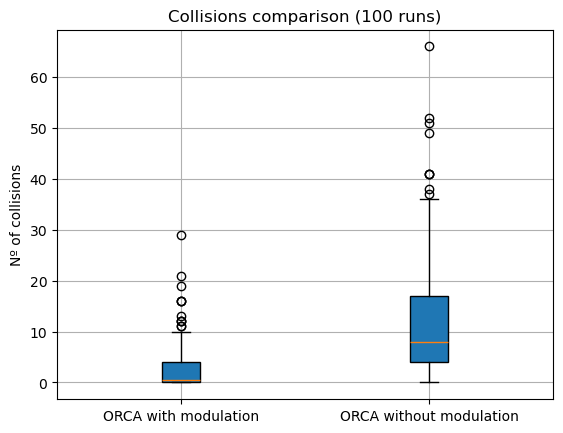

In [36]:
plt.boxplot([collisions_with, collisions_without], labels=['ORCA with modulation', 'ORCA without modulation'], patch_artist=True)
plt.title(f'Collisions comparison ({args.num_runs} runs)')
plt.ylabel('Nº of collisions')
plt.grid(True)
plt.savefig('plots/collisionscomparison_ORCA.png')
plt.show()

### Deadlocks comparison

To compare deadlocks we need to create a new function. This is because when using the modulation, an agent that is waiting for another one to cross a narrow area can be counted as a deadlock when it is not really stuck.

In [37]:
def real_deadlocks(run):
    states = [agent.behavior.state for agent in run.world.agents]
    return np.array([run.deadlocks[i] if states[i] == 0 else -1 for i in range(len(states))])    

In [39]:
deadlocks_without = [sum(run.deadlocks>0) for run in runs_without.values()]
np.mean(deadlocks_without)

0.0

In [40]:
deadlocks_with = [sum(real_deadlocks(run)>0) for run in runs_with.values()]
np.mean(deadlocks_with)

0.0

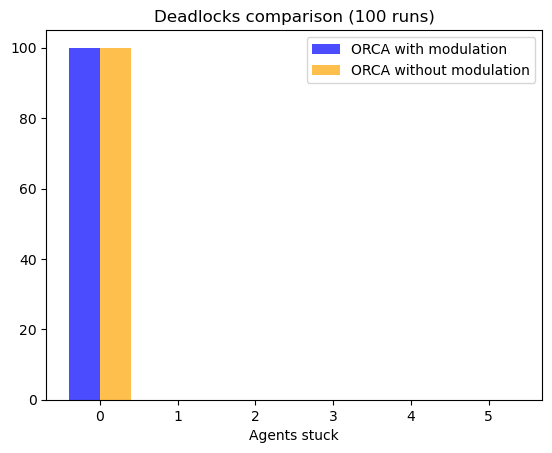

In [41]:
values = range(args.agents+1) 
freq_with = [deadlocks_with.count(v) for v in values]
freq_without = [deadlocks_without.count(v) for v in values]
x = np.arange(len(values))
width = 0.4
plt.bar(x - width/2, freq_with, width, label='ORCA with modulation', color='blue', alpha=0.7)
plt.bar(x + width/2, freq_without, width, label='ORCA without modulation', color='orange', alpha=0.7)
plt.xlabel('Agents stuck')
plt.ylabel('')
plt.title(f'Deadlocks comparison ({args.num_runs} runs)')
plt.xticks(x, values)  # Etiquetas de los valores
plt.legend()
plt.savefig('plots/deadlockscomparison_ORCA.png')
plt.show()

### Example of Deadlocks is incorrect

In [42]:
deadlocks_with[1]

0

In [43]:
poses_agent = [run.poses for run in runs_without.values()]
poses_agent[1][1950]

array([[  5.499977 ,   4.499981 ,  -5.588126 ],
       [  6.5519524,   6.5716147,  -6.298413 ],
       [  5.712382 ,   9.159836 ,  10.089204 ],
       [  7.644294 ,  10.873029 , -25.77812  ],
       [  8.944464 ,   3.5000017,  10.995573 ]], dtype=float32)

In [44]:
poses_agent = [run.poses for run in runs_without.values()]
poses_agent[1][1999]

array([[  5.499977 ,   4.499981 ,  -5.588126 ],
       [  9.253777 ,   6.513242 ,  -6.2956204],
       [  5.5260153,   8.91082  ,  10.670932 ],
       [  7.4064083,   6.6722493, -26.759457 ],
       [  8.944464 ,   3.5000017,  10.995573 ]], dtype=float32)

### NEW Deadlocks comparison

We have seen that the way run.deadlocks[i] is calculated is incorrect, since we observed in the previous example how up to two agents become immobilized and are not counted in the count of stuck agents. The following function calculates the agents in a deadlock state in a way that is more faithful to reality. It is passed 3 parameters: the execution where all the behavior of the agents occurs, the steps necessary to consider it immobilized, and whether it has modulation or not.

Hemos visto que el modo de calcular run.deadlocks[i] es incorecto ya que apreciamos en el ejemplo anterior como hasta dos agentes se quedan inmovilizados y no son contabilizados en el recuento de agentes stucked. la siguiente funcion calcula los agentes en estado deadlock de manera mas fiel a la realidad. Se le pasa 3 parametros: La ejecución donde se produce todo el comportamiento de los agentes, los pasos necesarios para considerarlo que esta inmovil y si tiene modulación o no.

In [45]:
def real_deadlocks_v2(run,steps_for_be_considered,modulation):
    """
   Calcula los agentes en estado deadlock de una simulacion y la devuelve en un np.array.

    Parameters:
        run sim.run(): Simulacion a la que se le calcula los agentes en estado deadlock.
        steps_for_be_considered (float): Numero de interaciones que el agente deba estar en estado deadlock para considerarlo finalmente.
        modulation(bool): Si se le aplica modulación o no

    Returns:
       deadlocks_agents (np.array): Array con valores de 1 y 0, si el agente esta o no en estado deadlock .
    """
    agents_poses = run.poses
    deadlocks_agents = []
    if modulation == True: # Si el conjunto de simulaciones tiene activada la modulacion es necesario tener encuenta el atributo state para saber si esta detenido porque esta esperando a otros agentes
        states = [agent.behavior.state for agent in run.world.agents]
    for agent in range(0,len(run.world.agents)):
        deadlock=0
        agent_poses_before = [0, 0, 0]
        steps_without_move=0
        for step in range(0,len(agents_poses)):
            distX = (agents_poses[step][agent][0] - agent_poses_before[0])**2 
            distY = (agents_poses[step][agent][1] - agent_poses_before[1])**2
            dist = math.sqrt(distX+distY) #Calculo de la distancia entre la posicion actual y la anterior
            actual_speed = dist/run.time_step #Calculo de la velocidad
            speed_considered = 1/100 #Velocidad maxima de un agente para considerarlo en estado deadlock
            if actual_speed < speed_considered: # Si la velocidad es menor a la considerada, determinamos que esta en estado deadlock una interación más 
                steps_without_move=steps_without_move+1 
            else:
                steps_without_move=0 # Si la velocidad NO es menor a la considerada, determinamos que YA NO esta en estado deadlock
            agent_poses_before = agents_poses[step][agent] # La posicion actual se convierte en la anterior
        if steps_without_move > steps_for_be_considered: # Si tiene mas interaciones en estado deadlock que lo considerado, se determina en estado deadlock permanente
            deadlock = 1
        if modulation == True: 
            if states[agent] == 1: # Si el agente esta esperadno a otros agentes no debe considerarse en estado deadlock
                deadlock = 0
        deadlocks_agents.append(deadlock)
            
    return np.array(deadlocks_agents)    

In [46]:
def real_deadlocks_v3(run,steps_for_be_considered,dist_for_be_considered,modulation):
    """
   Calcula los agentes en estado deadlock de una simulacion y la devuelve en un np.array.

    Parameters:
        run sim.run(): Simulacion a la que se le calcula los agentes en estado deadlock.
        steps_for_be_considered (float): Numero de interaciones que el agente deba estar en estado deadlock para considerarlo finalmente.
        dist_for_be_considered(float): Distancia maxima para considerar a un agente en estado deadlook.
        modulation(bool): Si se le aplica modulación o no

    Returns:
       deadlocks_agents (np.array): Array con valores de 1 y 0, si el agente esta o no en estado deadlock .
    """
    agents_poses = run.poses
    deadlocks_agents = []
    if modulation == True:
        states = [agent.behavior.state for agent in run.world.agents]
    for agent in range(0,len(run.world.agents)):
        deadlock=0
        agent_mean_poses = [0, 0, 0]
        steps_without_move=0
        for step in range(0,len(agents_poses)):
            
                if (abs(agents_poses[step][agent][0] - agent_mean_poses[0]) < dist_for_be_considered) and (abs(agents_poses[step][agent][1] - agent_mean_poses[1]) < dist_for_be_considered):
                    steps_without_move=steps_without_move+1
                    agent_mean_poses = [np.mean([agents_poses[step][agent][0],agent_mean_poses[0]]),np.mean([agents_poses[step][agent][1],agent_mean_poses[1]])]                                
                else:
                    steps_without_move=0
                    agent_mean_poses = agents_poses[step][agent]
        if steps_without_move > steps_for_be_considered:
            deadlock = 1
        if modulation == True:
            if states[agent] == 1:
                deadlock = 0
        deadlocks_agents.append(deadlock)
            
    return np.array(deadlocks_agents)    

In [563]:
display_video_from_run(run=runs_without[15], factor=4.0, fps=30)

In [47]:
def calcular_diferencias(array1, array2):
    """
    Resta los elementos de dos np.array() y devuelve una lista con las diferencias.

    Parameters:
        array1 (np.array): Primer array.
        array2 (np.array): Segundo array.

    Returns:
       array2 (np.array): Array con las diferencias elemento por elemento.
    """
    # Asegúrate de que ambos arrays tengan la misma forma
    if array1.shape != array2.shape:
        raise ValueError("Los arrays deben tener la misma forma para calcular las diferencias.")
    
    # Calcular las diferencias
    diferencias = array1 - array2
    
    # Convertir el resultado en una lista y devolverlo
    return np.array(diferencias)



In [48]:
def calcular_errores(lista):
    """
    Suma los elementos positivos y resta los negativos de una lista.

    Parameters:
        lista (list): Lista de números.

    Returns:
        list: Una lista con [suma_positivos, suma_negativos].
    """
    suma_positivos = sum(x for x in lista if x > 0)  # Suma de los números positivos
    suma_negativos = sum(x for x in lista if x < 0)  # Suma (resta) de los números negativos
    
    return [suma_positivos, suma_negativos]

In [49]:
deadlocks_observed = [0,1,2,4,1,2,2,1,0,2,1,1,2,1,1,5,1,3,3,2]
print(deadlocks_observed)
np.mean(deadlocks_observed)

[0, 1, 2, 4, 1, 2, 2, 1, 0, 2, 1, 1, 2, 1, 1, 5, 1, 3, 3, 2]


1.75

In [50]:
deadlocks_without_2 = [sum(real_deadlocks_v2(run,(2/100)*len(run.poses),False)>0) for run in runs_without.values()]
print(deadlocks_without_2)
np.mean(deadlocks_without_2)

[0, 2, 2, 1, 1, 1, 1, 2, 1, 1, 4, 5, 1, 4, 3, 0, 3, 2, 0, 1, 4, 2, 1, 2, 2, 2, 1, 2, 0, 3, 2, 0, 4, 1, 1, 0, 3, 1, 2, 2, 2, 2, 0, 2, 3, 1, 1, 2, 3, 2, 1, 4, 0, 2, 3, 1, 1, 2, 1, 2, 2, 2, 2, 3, 0, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1, 0, 2, 2, 2, 2, 3, 2, 3, 2, 4, 2, 3]


1.68

In [51]:
deadlocks_without_3 = [sum(real_deadlocks_v3(run,(2/100)*len(run.poses),(2/1000),False)>0) for run in runs_without.values()]
print(deadlocks_without_3)
np.mean(deadlocks_without_3)

[0, 2, 2, 1, 1, 1, 1, 2, 1, 1, 4, 5, 1, 4, 3, 0, 3, 2, 0, 1, 4, 2, 1, 2, 2, 2, 1, 2, 0, 3, 2, 1, 4, 1, 1, 0, 3, 2, 2, 2, 2, 2, 0, 2, 3, 1, 1, 2, 4, 2, 1, 4, 0, 2, 3, 1, 1, 2, 1, 2, 2, 2, 2, 3, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 3, 0, 2, 2, 1, 1, 2, 1, 1, 0, 2, 2, 2, 2, 3, 2, 3, 2, 4, 2, 3]


1.73

In [558]:
resultado_without_2 = calcular_diferencias(np.array(deadlocks_observed), np.array(deadlocks_without_2))
print(f"Diferencias: {resultado_without_2}")
print("Deadlocks Observados: ", np.sum(deadlocks_observed))
print("Deadlocks Detactados: ", np.sum(deadlocks_without_2))
print("Deadlocks errados: De menos/De mas: ", calcular_errores(resultado_without_2))

Diferencias: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
Deadlocks Observados:  35
Deadlocks Detactados:  30
Deadlocks errados: De menos/De mas:  [5, 0]


In [560]:
resultado_without_3 = calcular_diferencias(np.array(deadlocks_observed), np.array(deadlocks_without_3))
print(f"Diferencias: {resultado_without_3}")
print("Deadlocks Observados: ", np.sum(deadlocks_observed))
print("Deadlocks Detactados: ", np.sum(deadlocks_without_3))
print("Deadlocks errados: De menos/De mas: ", calcular_errores(resultado_without_3))

Diferencias: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
Deadlocks Observados:  35
Deadlocks Detactados:  30
Deadlocks errados: De menos/De mas:  [5, 0]


In [53]:
deadlocks_with_2 = [sum(real_deadlocks_v2(run,(2/100)*len(run.poses),True)>0) for run in runs_with.values()]
print(deadlocks_with_2)
np.mean(deadlocks_with_2)

[0, 3, 2, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 0, 2, 0, 3, 3, 2, 0, 0, 1, 1, 4, 0, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 2, 2, 0, 1, 3, 1, 1, 0, 1, 1, 1, 0, 3, 3, 3, 1, 1, 3, 0, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 5, 5, 0, 0, 1, 0, 2, 0, 0, 0, 2, 1]


0.93

In [59]:
deadlocks_with_2 = [0, 3, 2, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 0, 2, 0, 3, 3, 2, 0, 0, 1, 1, 4, 0, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 2, 2, 0, 1, 3, 1, 1, 0, 1, 1, 1, 0, 3, 3, 3, 1, 1, 3, 0, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 4, 5, 0, 0, 1, 0, 2, 0, 0, 0, 2, 1]

In [57]:
deadlocks_with_3 = [sum(real_deadlocks_v3(run,(2/100)*len(run.poses),(2/1000),True)>0) for run in runs_with.values()]
print(deadlocks_with_3)
np.mean(deadlocks_with_3)

[0, 3, 2, 2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 0, 2, 0, 3, 3, 2, 0, 1, 1, 1, 4, 1, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 3, 2, 0, 1, 3, 1, 1, 0, 1, 1, 1, 0, 3, 3, 3, 1, 1, 3, 0, 1, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 5, 5, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1]


1.0

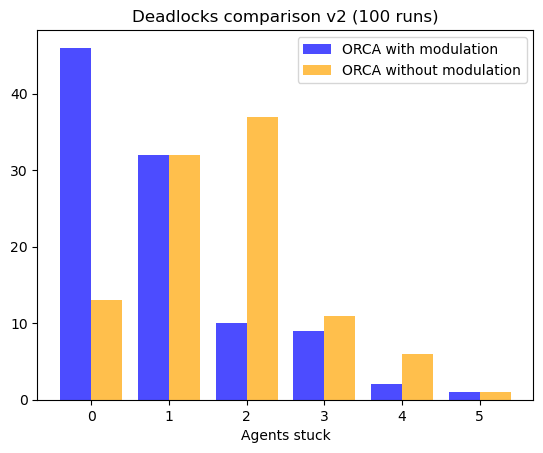

In [60]:
values = range(args.agents+1) 
freq_with = [deadlocks_with_2.count(v) for v in values]
freq_without = [deadlocks_without_2.count(v) for v in values]
x = np.arange(len(values))
width = 0.4
plt.bar(x - width/2, freq_with, width, label='ORCA with modulation', color='blue', alpha=0.7)
plt.bar(x + width/2, freq_without, width, label='ORCA without modulation', color='orange', alpha=0.7)
plt.xlabel('Agents stuck')
plt.ylabel('')
plt.title(f'Deadlocks comparison v2 ({args.num_runs} runs)')
plt.xticks(x, values)  # Etiquetas de los valores
plt.legend()
plt.savefig('plots/deadlockscomparison_ORCA.png')
plt.show()

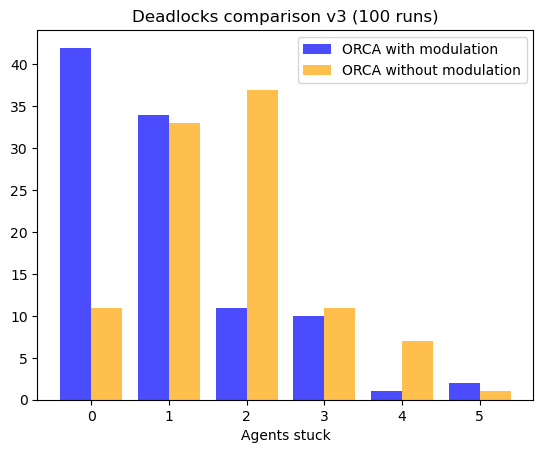

In [58]:
values = range(args.agents+1) 
freq_with = [deadlocks_with_3.count(v) for v in values]
freq_without = [deadlocks_without_3.count(v) for v in values]
x = np.arange(len(values))
width = 0.4
plt.bar(x - width/2, freq_with, width, label='ORCA with modulation', color='blue', alpha=0.7)
plt.bar(x + width/2, freq_without, width, label='ORCA without modulation', color='orange', alpha=0.7)
plt.xlabel('Agents stuck')
plt.ylabel('')
plt.title(f'Deadlocks comparison v3 ({args.num_runs} runs)')
plt.xticks(x, values)  # Etiquetas de los valores
plt.legend()
plt.savefig('plots/deadlockscomparison_ORCA.png')
plt.show()

### Efficacy comparison

When all the agents get stuck and the simulation stops early, we must fill the efficacy array with 0s.

In [573]:
efficacies_without = []
for run in runs_without.values():
    run_steps, agents = run.efficacy.shape
    if run_steps < args.steps:
        efficacies_without += [np.mean(np.vstack((run.efficacy, np.zeros((args.steps - run_steps, agents)))))]
    else:
        efficacies_without += [np.mean(run.efficacy)]
print(np.mean(efficacies_without))

0.2167007


In [574]:
efficacies_with = []
for run in runs_with.values():
    run_steps, agents = run.efficacy.shape
    if run_steps < args.steps:
        efficacies_with += [np.mean(np.vstack((run.efficacy, np.zeros((args.steps - run_steps, agents)))))]
    else:
        efficacies_with += [np.mean(run.efficacy)]
print(np.mean(efficacies_with))

0.15517452
